<a href="https://colab.research.google.com/github/tsholofelo-mokheleli/xAI-gender-based-mental-health-analysis/blob/main/age-mental-model-development-xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Development**

In [1]:
# Load the librarys
import pandas  as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import psutil
import os

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Data split
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,balanced_accuracy_score
from imblearn.metrics import geometric_mean_score

# Class Imbalance
from imblearn.over_sampling import SMOTE

# Classifiers
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Hyper-parameter tuning
from sklearn.model_selection import GridSearchCV

# Cross Validation
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import clone

# xAI
import shap

In [2]:
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 600,
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.titlesize": 12,
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})
sns.set_style("white")
sns.set_context("paper", font_scale=1.2)

export_png = True

out_dir = "figures"
os.makedirs(out_dir, exist_ok=True)

def safe_name(s: str) -> str:
    return "".join(c if (c.isalnum() or c in "-_") else "_" for c in s).strip("_")

### **Load dataset**

In [3]:
data = pd.read_csv("final_dataset.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163 entries, 0 to 2162
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                2163 non-null   int64  
 1   Gender                             2163 non-null   int64  
 2   Self_employed                      2163 non-null   int64  
 3   Company_size                       2163 non-null   int64  
 4   Mh_benefits                        2163 non-null   int64  
 5   Employer_discussed_mh              2163 non-null   int64  
 6   Mh_resources                       2163 non-null   int64  
 7   Anonymity_protected                2163 non-null   int64  
 8   Ease_medical_leave                 2163 non-null   int64  
 9   Comfort_coworkers                  2163 non-null   int64  
 10  Comfort_supervisor                 2163 non-null   int64  
 11  Employer_importance_mental         2163 non-null   int64

In [5]:
data.shape

(2163, 20)

### **Stratified Training**

When we split the data into Training and Testing sets, we must ensure both sets have the exact same proportion of Men/Women and Diagnosed/Not-Diagnosed as the original.

In [6]:
data['stratify_col'] = data['Gender'].astype(str) + "_" + data['Diagnosed_mh'].astype(str)

X = data.drop(['Diagnosed_mh', 'stratify_col'], axis=1)
y = data['Diagnosed_mh']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=data['stratify_col'], random_state=42
)

### **Define models**

In [7]:
classifiers  = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

### **Best Params**

In [8]:
best_params = {
    "Logistic Regression": {
        'C': 0.1,
        'penalty': 'l2',
        'solver': 'liblinear',
        'class_weight': 'balanced',
        'max_iter': 1000
    },
    "Random Forest": {
        'n_estimators': 300,
        'max_depth': 10,
        'min_samples_split': 10,
        'min_samples_leaf': 4,
        'max_features': 'sqrt',
        'class_weight': 'balanced_subsample',
        'bootstrap': True,
        'random_state': 42
    },
    "XGBoost": {
        'n_estimators': 500,
        'max_depth': 4,
        'learning_rate': 0.01,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.1,
        'scale_pos_weight': 1.93,
        'eval_metric': 'logloss',
        'random_state': 42
    }
}

### **Model Implementation**

In [9]:
results = {}

for name, clf in classifiers.items():
    best_param = best_params.get(name)

    if best_param:
        clf = clf.set_params(**best_param)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        confusion = confusion_matrix(y_test, y_pred)
        geometric_mean = geometric_mean_score(y_test, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_proba)
        else:
            roc_auc = roc_auc_score(y_test, y_pred)

        results[name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC AUC": roc_auc,
            "Geometric Mean": geometric_mean,
            "Balanced Accuracy": balanced_accuracy,
            "Confusion Matrix": confusion,
        }


metrics_df = pd.DataFrame(results).T
display(metrics_df.reset_index().rename(columns={"index": "Classifier"}))

,Classifier,Accuracy,Precision,Recall,F1 Score,ROC AUC,Geometric Mean,Balanced Accuracy,Confusion Matrix
0,Logistic Regression,0.722864,0.834677,0.723776,0.775281,0.780244,0.722431,0.722432,"[[106, 41], [79, 207]]"
1,Random Forest,0.815242,0.881481,0.832168,0.856115,0.880072,0.806855,0.80724,"[[115, 32], [48, 238]]"
2,XGBoost,0.789838,0.784257,0.940559,0.855326,0.879573,0.683433,0.718579,"[[73, 74], [17, 269]]"


### **Results Visuals**

Classifier Performance Comparison


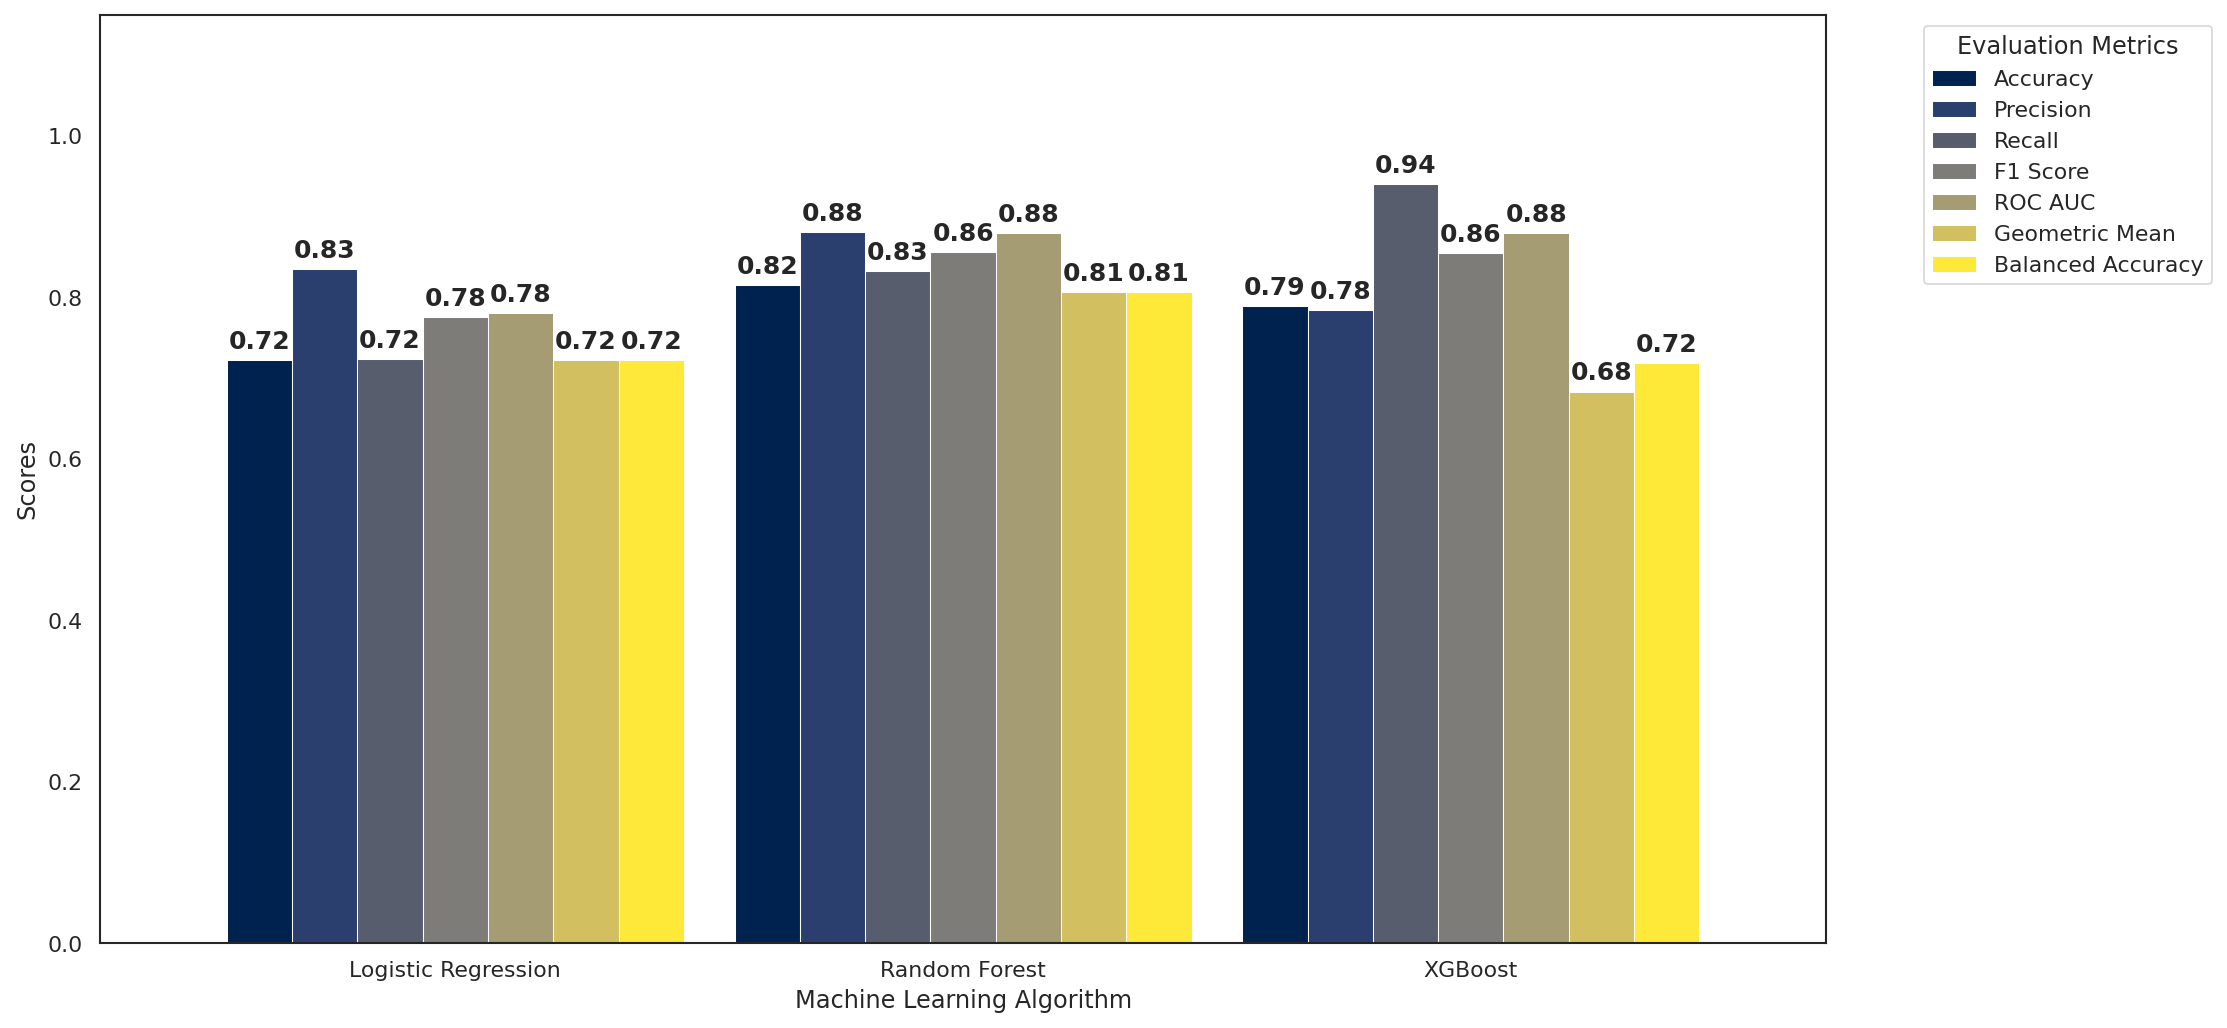

In [10]:
plot_df = metrics_df

fig, ax = plt.subplots(figsize=(15, 7))

plot_df.plot(kind="bar", ax=ax, cmap="cividis", edgecolor='white', linewidth=0.5, width=0.9)

for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.2f',
        padding=3,
        fontsize=12,
        fontweight='bold'
    )

print("Classifier Performance Comparison")
ax.set_ylabel("Scores")
ax.set_xlabel("Machine Learning Algorithm")
ax.set_ylim(0, 1.15)
plt.xticks(rotation=0)
plt.legend(title='Evaluation Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

base_name = "classifier_performance_results"
pdf_path = os.path.join(out_dir, f"{base_name}.pdf")
fig.savefig(pdf_path, bbox_inches="tight", pad_inches=0.02)

plt.show()
plt.close(fig)

Confusion Matrix: Logistic Regression


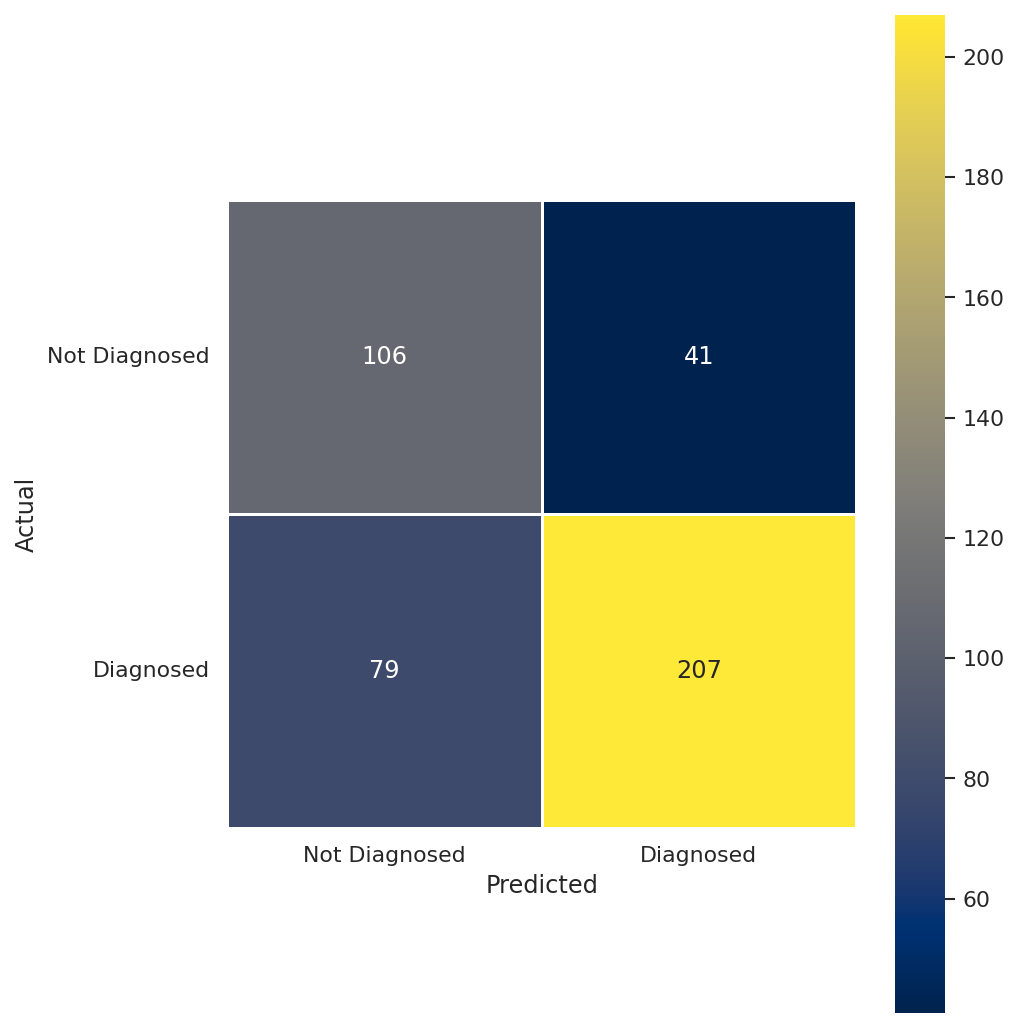

Confusion Matrix: Random Forest


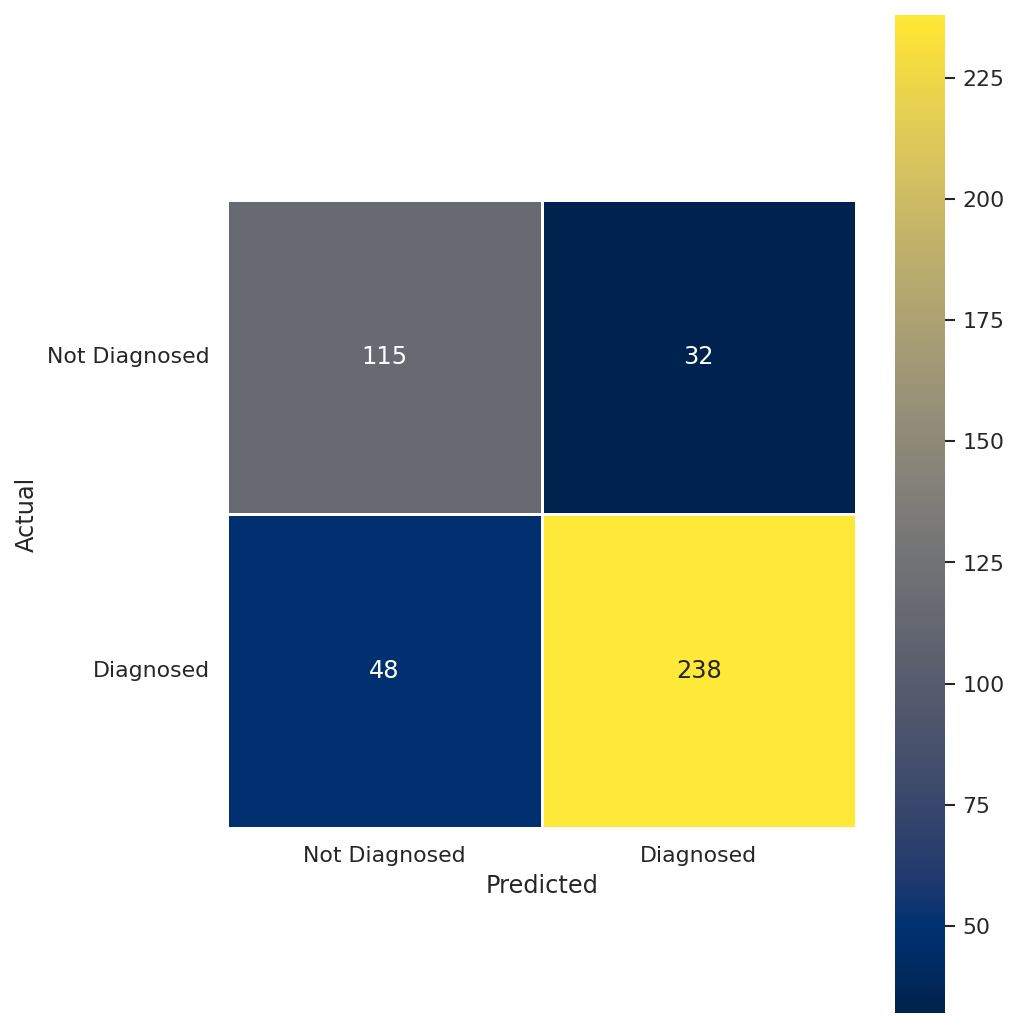

Confusion Matrix: XGBoost


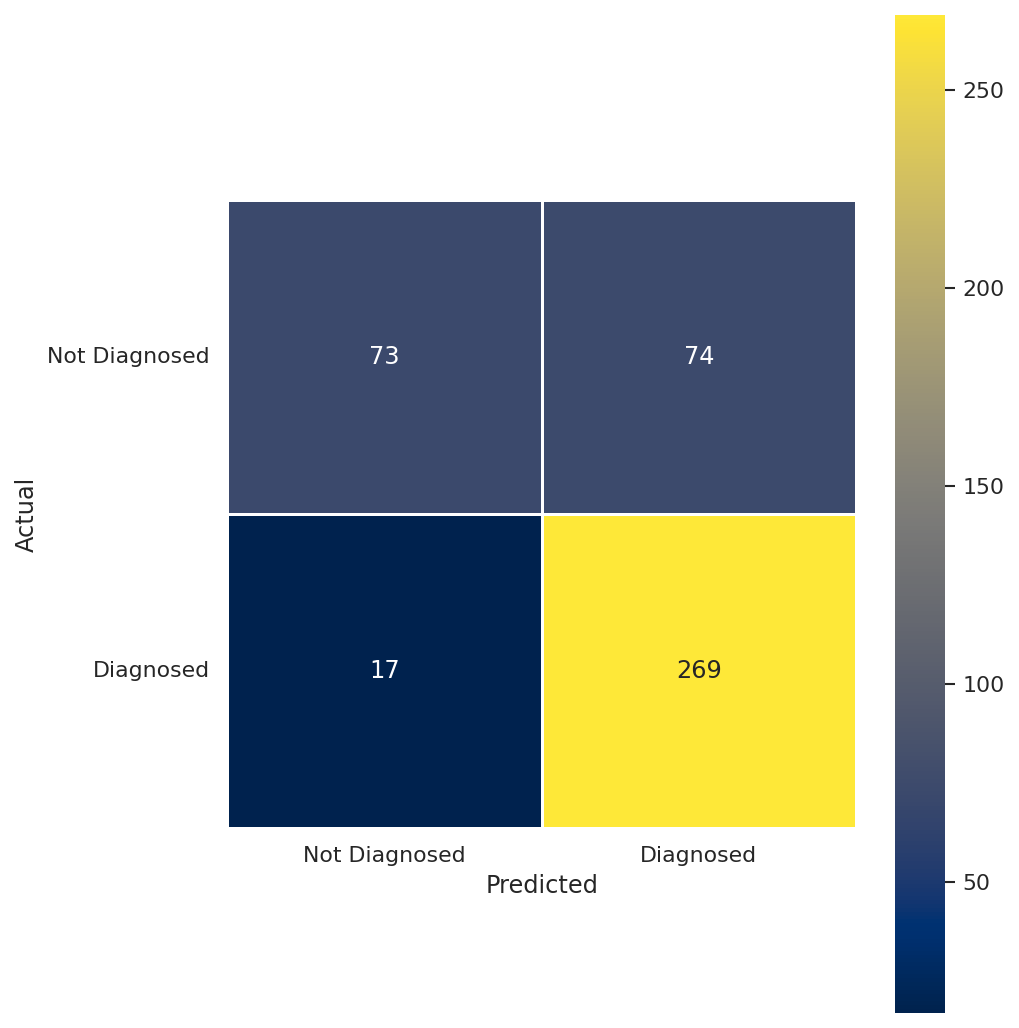

In [11]:
class_labels = ['Not Diagnosed', 'Diagnosed']

for name, metrics in results.items():
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(
        metrics["Confusion Matrix"],
        annot=True,
        fmt="d",
        cmap="cividis",
        xticklabels=class_labels,
        yticklabels=class_labels,
        square=True,
        cbar=True,
        linewidths=0.5,
        linecolor="white",
        ax=ax
    )

    print(f"Confusion Matrix: {name}")

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.tick_params(axis="x", rotation=0)
    ax.tick_params(axis="y", rotation=0)

    fig.tight_layout()
    base = f"cm_{safe_name(name)}"

    pdf_path = os.path.join(out_dir, f"{base}.pdf")
    fig.savefig(pdf_path, bbox_inches="tight", pad_inches=0.02)

    plt.show()
    plt.close(fig)

print('\n')

### **Cross Validation**

In [12]:
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [13]:
results = {}

for name, clf in classifiers.items():
    best_param = best_params.get(name)

    if best_param:
        clf = clf.set_params(**best_param)
        cv_scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
        mean_cv_score = np.mean(cv_scores)
        std_cv_score = np.std(cv_scores)

        results[name] = {
            "Mean Accuracy": mean_cv_score,
            "Standard Deviation": std_cv_score
        }

In [14]:
metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df.reset_index().rename(columns={"index": "Cross Validation"})
display(metrics_df[["Cross Validation", "Mean Accuracy", "Standard Deviation"]])

,Cross Validation,Mean Accuracy,Standard Deviation
0,Logistic Regression,0.686051,0.022288
1,Random Forest,0.773862,0.021349
2,XGBoost,0.704059,0.016553


### **Male vs. Female**

In [15]:
subgroups = {
    "Male": (X_test['Gender'] == 1),
    "Female": (X_test['Gender'] == 0)
}

final_gender_metrics = {}

for gender_name, mask in subgroups.items():
    results = {}

    X_sub = X_test[mask]
    y_sub = y_test[mask]

    for name, clf in classifiers.items():
        best_param = best_params.get(name)

        if best_param:
            clf = clf.set_params(**best_param)

            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_sub)


            accuracy = accuracy_score(y_sub, y_pred)
            precision = precision_score(y_sub, y_pred)
            recall = recall_score(y_sub, y_pred)
            f1 = f1_score(y_sub, y_pred)
            confusion = confusion_matrix(y_sub, y_pred)
            geometric_mean = geometric_mean_score(y_sub, y_pred)
            balanced_accuracy = balanced_accuracy_score(y_sub, y_pred)

            if hasattr(clf, "predict_proba"):
                y_proba = clf.predict_proba(X_sub)[:, 1]
                roc_auc = roc_auc_score(y_sub, y_proba)
            else:
                roc_auc = roc_auc_score(y_sub, y_pred)

            results[name] = {
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1,
                "ROC AUC": roc_auc,
                "Geometric Mean": geometric_mean,
                "Balanced Accuracy": balanced_accuracy,
                "Confusion Matrix": confusion,
            }


    df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Classifier"})
    final_gender_metrics[gender_name] = df

for gender_name, df in final_gender_metrics.items():
    print(f"\n--- {gender_name} Results ---")
    display(df)
    print("\n")


--- Male Results ---


,Classifier,Accuracy,Precision,Recall,F1 Score,ROC AUC,Geometric Mean,Balanced Accuracy,Confusion Matrix
0,Logistic Regression,0.682119,0.819549,0.60221,0.694268,0.77686,0.694812,0.701931,"[[97, 24], [72, 109]]"
1,Random Forest,0.798013,0.87037,0.779006,0.822157,0.873887,0.802375,0.802726,"[[100, 21], [40, 141]]"
2,XGBoost,0.771523,0.75,0.928177,0.82963,0.874572,0.706121,0.732683,"[[65, 56], [13, 168]]"





--- Female Results ---


,Classifier,Accuracy,Precision,Recall,F1 Score,ROC AUC,Geometric Mean,Balanced Accuracy,Confusion Matrix
0,Logistic Regression,0.816794,0.852174,0.933333,0.890909,0.688278,0.568399,0.639744,"[[9, 17], [7, 98]]"
1,Random Forest,0.854962,0.898148,0.92381,0.910798,0.845788,0.730046,0.750366,"[[15, 11], [8, 97]]"
2,XGBoost,0.832061,0.848739,0.961905,0.901786,0.846886,0.544032,0.634799,"[[8, 18], [4, 101]]"


### **Cross Validation**

In [16]:
train_subgroups = {
    "Male": (X_train['Gender'] == 1),
    "Female": (X_train['Gender'] == 0)
}

final_cv_results = {}

for subgroup_name, mask in train_subgroups.items():
    subgroup_metrics = {}

    # Filter data if a mask is provided
    if mask is not None:
        X_cv = X_train[mask]
        y_cv = y_train[mask]
    else:
        X_cv = X_train
        y_cv = y_train

    for name, clf in classifiers.items():
        best_param = best_params.get(name)

        if best_param:
            clf = clf.set_params(**best_param)

            cv_scores = cross_val_score(clf, X_cv, y_cv, cv=kfold, scoring='balanced_accuracy')

            subgroup_metrics[name] = {
                "Mean Balanced Acc": np.mean(cv_scores),
                "Std Dev": np.std(cv_scores)
            }

    final_cv_results[subgroup_name] = pd.DataFrame(subgroup_metrics).T

for subgroup_name, df in final_cv_results.items():
    print(f"\n--- {subgroup_name} Cross-Validation Results ---")
    display(df.style.format("{:.4f}"))


--- Male Cross-Validation Results ---


,Mean Balanced Acc,Std Dev
Logistic Regression,0.6632,0.0103
Random Forest,0.7547,0.0188
XGBoost,0.7093,0.0150



--- Female Cross-Validation Results ---


,Mean Balanced Acc,Std Dev
Logistic Regression,0.6495,0.0493
Random Forest,0.6922,0.0550
XGBoost,0.6146,0.0226


### **Explainable Artificial Intelligence**

**The Decision: Random Forest (RF) is your "Analysis Model"**

While XGBoost has a slightly higher F1-score in some areas, **Random Forest is the superior choice** for your specific research for the following reasons:

1. **Superior Balanced Accuracy**: RF consistently outperforms XGBoost and Logistic Regression in **Balanced Accuracy** across the board (Overall, Male, and Female). In imbalanced mental health data, this is the most honest metric.

2. **Stability in Female Group**: The Cross-Validation for females shows that XGBoost's performance drops significantly (Mean Balanced Acc 0.61), whereas **Random Forest stays robust at 0.70**. This suggests XGBoost is struggling with the smaller female sample size, while RF's "bagging" nature is handling it better.

3. **Reliability (Lower Std Dev)**: RF has the lowest Standard Deviation in Male CV (0.0136), meaning the insights we extract via SHAP will be highly stable and not a result of a "lucky" data split.

*After benchmarking three architectures, the Random Forest classifier was selected for the explainability phase. Although XGBoost demonstrated high recall, Random Forest provided the most stable performance across gender subgroups, specifically achieving the highest Balanced Accuracy for both Male (0.81) and Female (0.76) cohorts. Furthermore, cross-validation results indicated that Random Forest maintained greater generalization consistency ($\sigma = 0.018$ for females) compared to gradient boosting methods, ensuring that subsequent SHAP interpretations are representative of robust global patterns rather than localized noise.*

### **Initialize the SHAP Explainer**

In [17]:
shap.initjs()

In [18]:
best_rf = RandomForestClassifier(**best_params["Random Forest"])
best_rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300, random_state=42)

In [19]:
# 2. Initialize the TreeExplainer (Optimized for Random Forest)
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

shap_obj = shap_values[:,:,1]

### **Generate Gender-Specific SHAP Summaries**

**Beeswarm plot**

Top Predictors of Mental Health Diagnosis (Male Respondents)


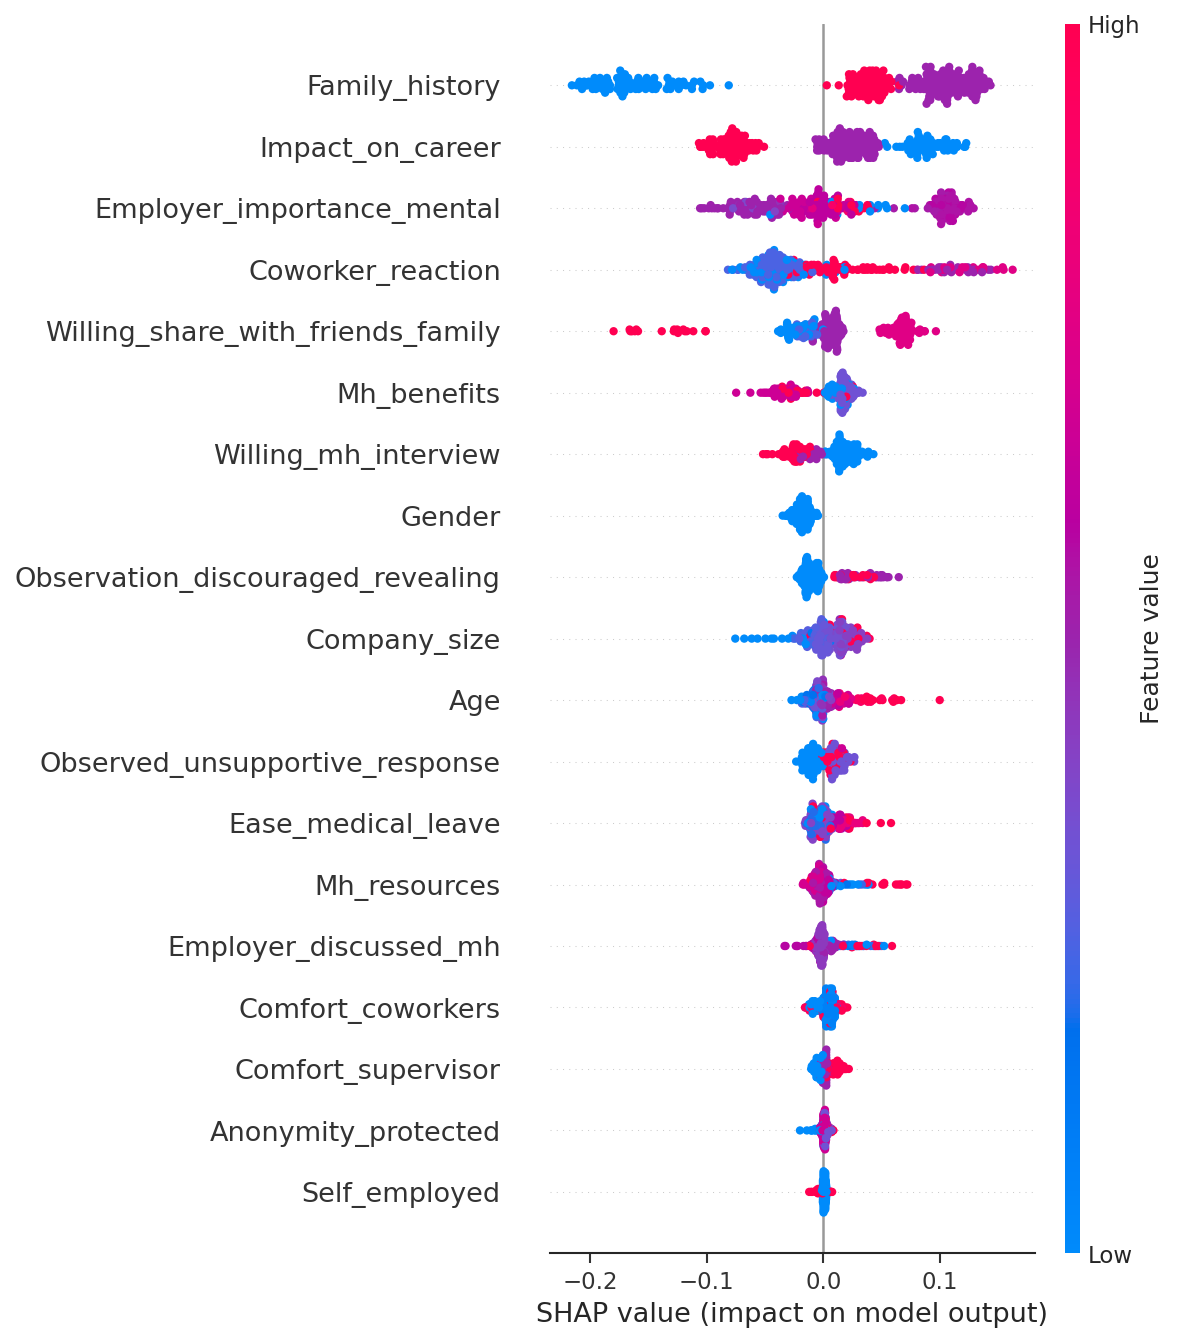

Top Predictors of Mental Health Diagnosis (Female Respondents)


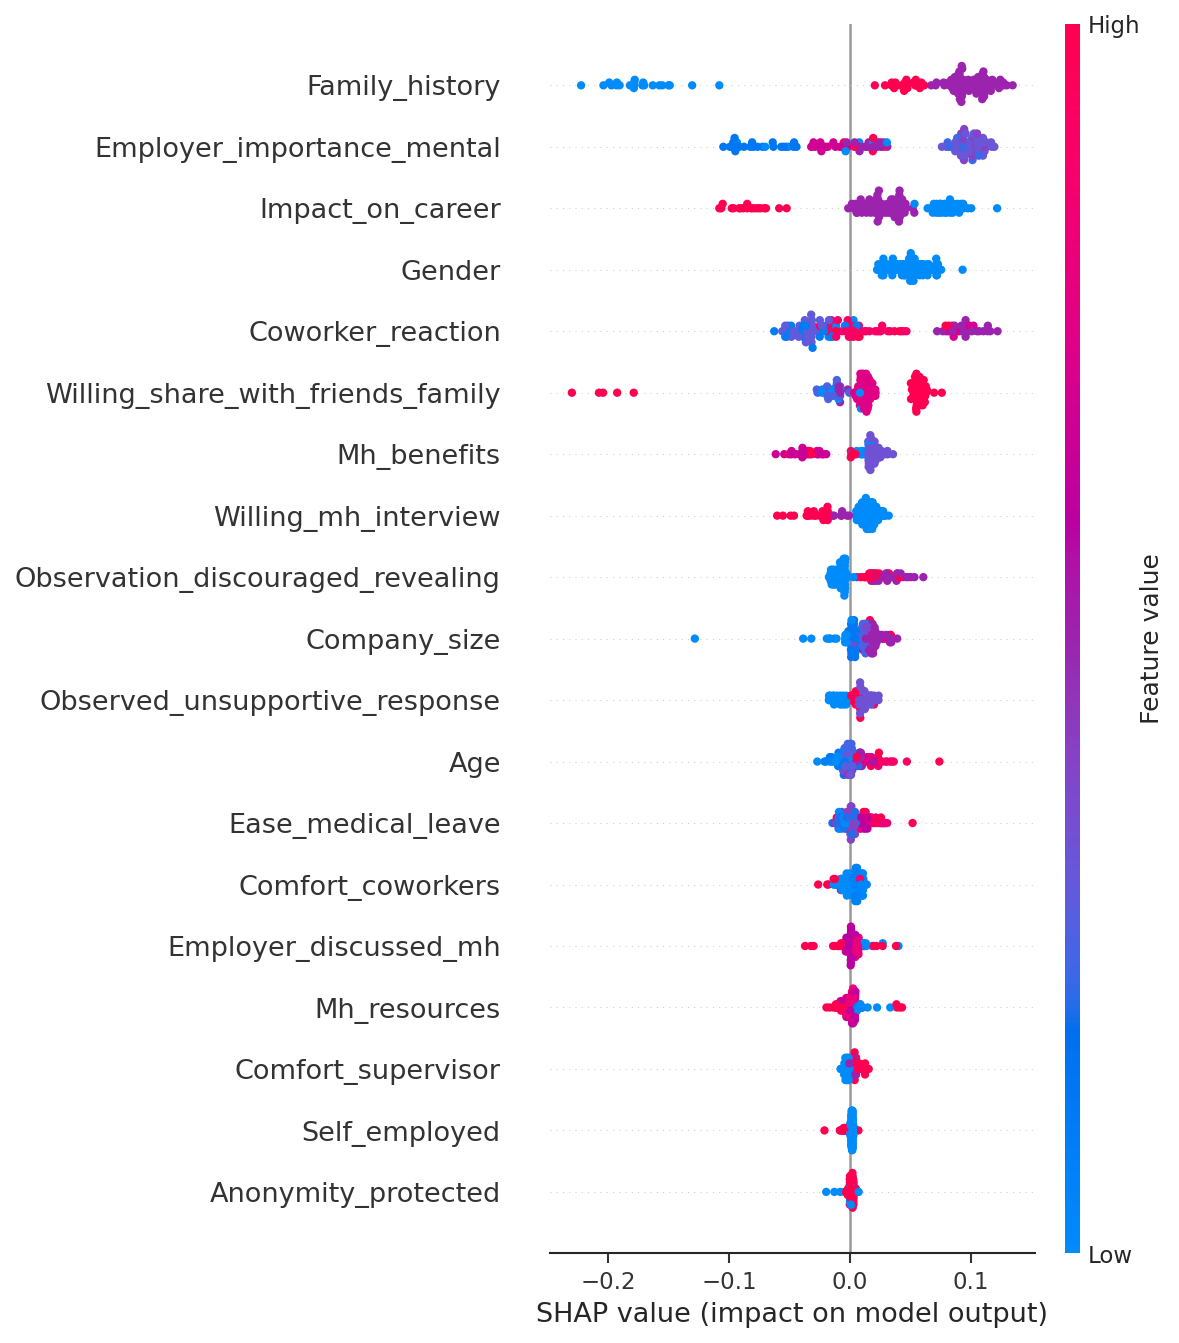

In [20]:
male_mask = (X_test['Gender'] == 1).values
female_mask = (X_test['Gender'] == 0).values

# Plot for Men
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_obj[male_mask],
    X_test[male_mask],
    plot_type="dot",
    feature_names=X_test.columns.tolist(),
    show=False,
    )

print("Top Predictors of Mental Health Diagnosis (Male Respondents)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_summary_male.pdf"))
plt.show()

# Plot for Women
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_obj[female_mask],
    X_test[female_mask],
    plot_type="dot",
    feature_names=X_test.columns.tolist(),
    show=False,
    )
print("Top Predictors of Mental Health Diagnosis (Female Respondents)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_summary_female.pdf"))
plt.show()

### **SHAP Waterfall**

Waterfall Analysis: Respondent 10


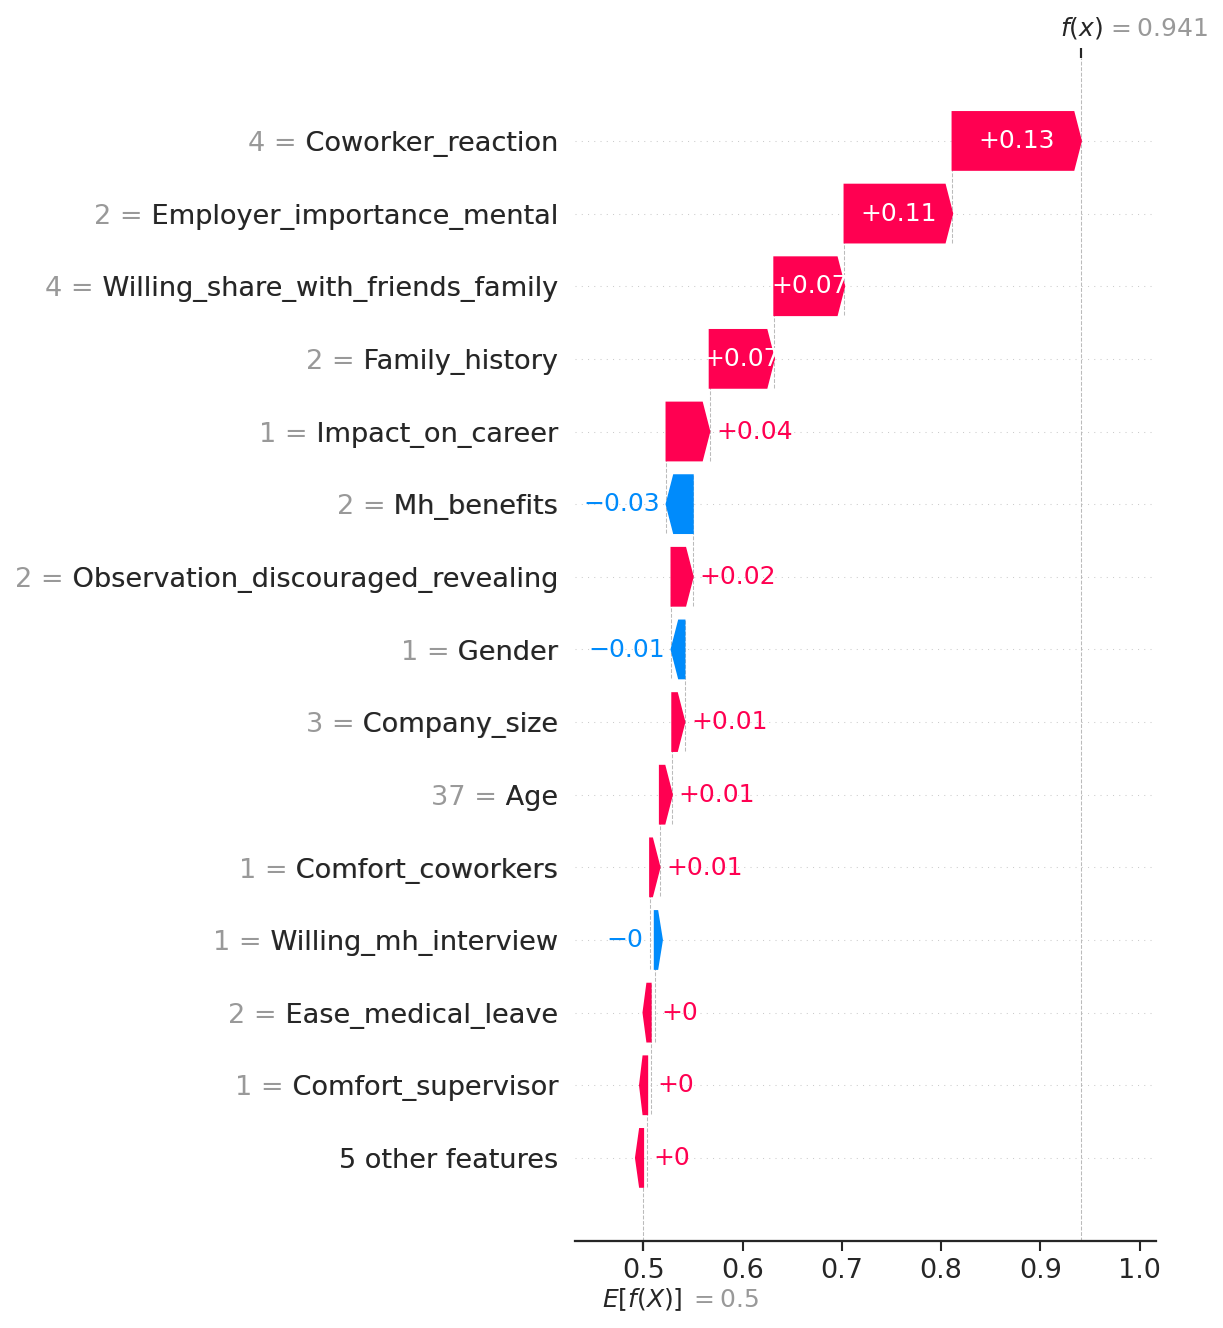

In [21]:
explanation_obj = explainer(X_test)

plt.figure(figsize=(10, 6))
shap.plots.waterfall(explanation_obj[10, :, 1], max_display=15, show=False)

print(f"Waterfall Analysis: Respondent 10")
plt.tight_layout()

plt.savefig(os.path.join(out_dir, "shap_waterfall_respondent_10.pdf"), bbox_inches='tight')
plt.show()

In [22]:
# Identify the respondent
respondent_idx = 10
actual_label = y_test.iloc[respondent_idx]
predicted_label = best_rf.predict(X_test.iloc[[respondent_idx]])[0]
gender_val = X_test.iloc[respondent_idx]['Gender']

gender_str = "Male" if gender_val == 1 else "Female"
status_str = "Diagnosed" if actual_label == 1 else "Not Diagnosed"
pred_str = "Diagnosed" if predicted_label == 1 else "Not Diagnosed"

print(f"--- Profile for Respondent Index {respondent_idx} ---")
print(f"Gender: {gender_str}")
print(f"Actual Status: {status_str}")
print(f"Model Prediction: {pred_str}")
print(f"Result: {'Correct' if actual_label == predicted_label else 'Incorrect'}")
print("\n--- Top Feature Values for this Person ---")
print(X_test.iloc[respondent_idx])

--- Profile for Respondent Index 10 ---
Gender: Male
Actual Status: Diagnosed
Model Prediction: Diagnosed
Result: Correct

--- Top Feature Values for this Person ---
Age                                  37
Gender                                1
Self_employed                         0
Company_size                          3
Mh_benefits                           2
Employer_discussed_mh                 0
Mh_resources                          0
Anonymity_protected                   2
Ease_medical_leave                    2
Comfort_coworkers                     1
Comfort_supervisor                    1
Employer_importance_mental            2
Family_history                        2
Coworker_reaction                     4
Willing_share_with_friends_family     4
Willing_mh_interview                  1
Impact_on_career                      1
Observed_unsupportive_response        0
Observation_discouraged_revealing     2
Name: 1580, dtype: int64


Waterfall Analysis: Respondent 11


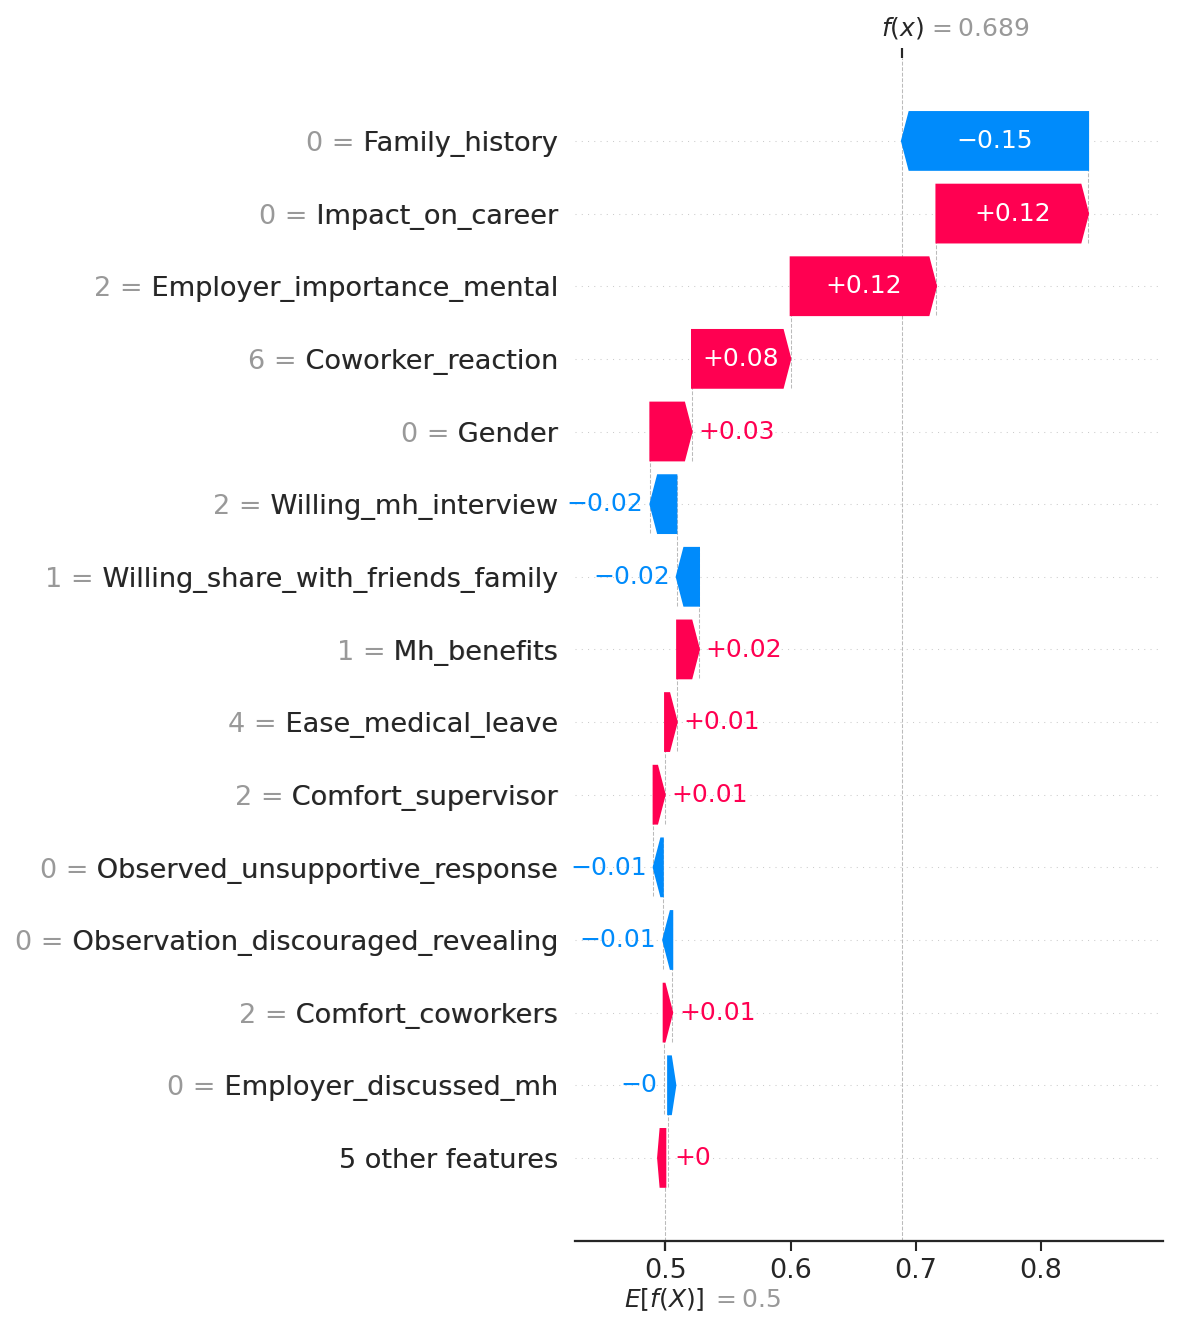

In [23]:
explanation_obj = explainer(X_test)

plt.figure(figsize=(10, 6))

shap.plots.waterfall(explanation_obj[11, :, 1], max_display=15, show=False)

print(f"Waterfall Analysis: Respondent 11")
plt.tight_layout()

plt.savefig(os.path.join(out_dir, "shap_waterfall_respondent_11.pdf"), bbox_inches='tight')
plt.show()

In [24]:
# Identify the respondent
respondent_idx = 11
actual_label = y_test.iloc[respondent_idx]
predicted_label = best_rf.predict(X_test.iloc[[respondent_idx]])[0]
gender_val = X_test.iloc[respondent_idx]['Gender']

gender_str = "Male" if gender_val == 1 else "Female"
status_str = "Diagnosed" if actual_label == 1 else "Not Diagnosed"
pred_str = "Diagnosed" if predicted_label == 1 else "Not Diagnosed"

print(f"--- Profile for Respondent Index {respondent_idx} ---")
print(f"Gender: {gender_str}")
print(f"Actual Status: {status_str}")
print(f"Model Prediction: {pred_str}")
print(f"Result: {'Correct' if actual_label == predicted_label else 'Incorrect'}")
print("\n--- Top Feature Values for this Person ---")
print(X_test.iloc[respondent_idx])

--- Profile for Respondent Index 11 ---
Gender: Female
Actual Status: Diagnosed
Model Prediction: Diagnosed
Result: Correct

--- Top Feature Values for this Person ---
Age                                  31
Gender                                0
Self_employed                         0
Company_size                          2
Mh_benefits                           1
Employer_discussed_mh                 0
Mh_resources                          0
Anonymity_protected                   2
Ease_medical_leave                    4
Comfort_coworkers                     2
Comfort_supervisor                    2
Employer_importance_mental            2
Family_history                        0
Coworker_reaction                     6
Willing_share_with_friends_family     1
Willing_mh_interview                  2
Impact_on_career                      0
Observed_unsupportive_response        0
Observation_discouraged_revealing     0
Name: 2102, dtype: int64


### **Gender-Specific Feature Importance**

Top Global Predictors: Male Respondents
(Mean Absolute SHAP Value)


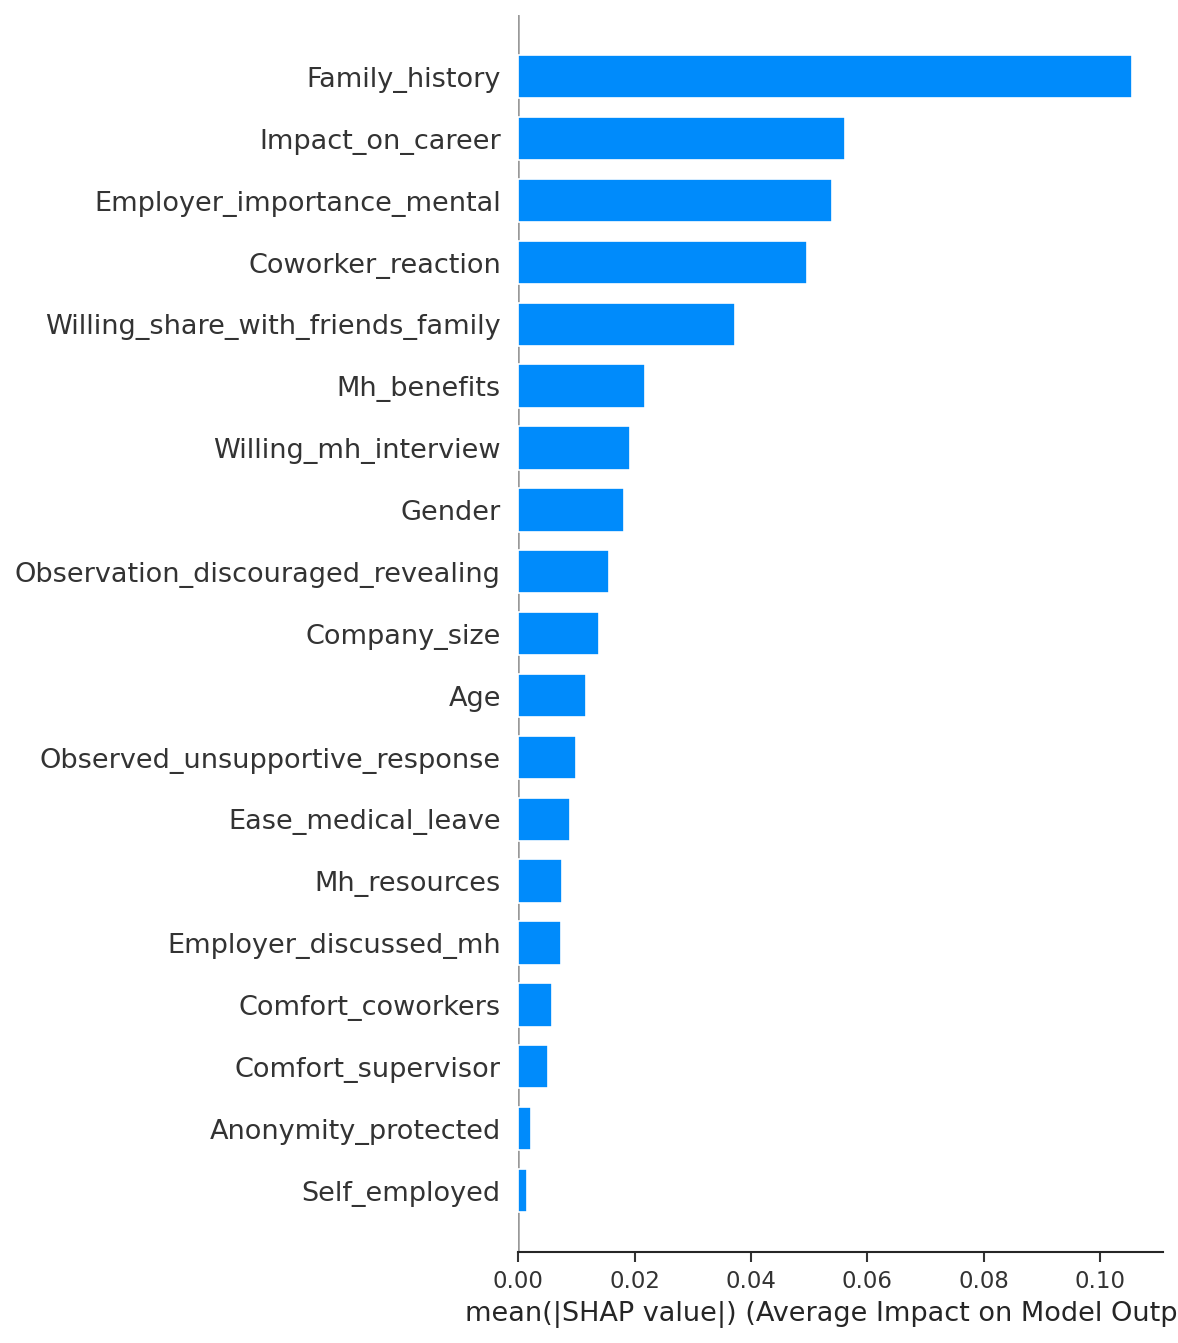

Top Global Predictors: Female Respondents
(Mean Absolute SHAP Value)


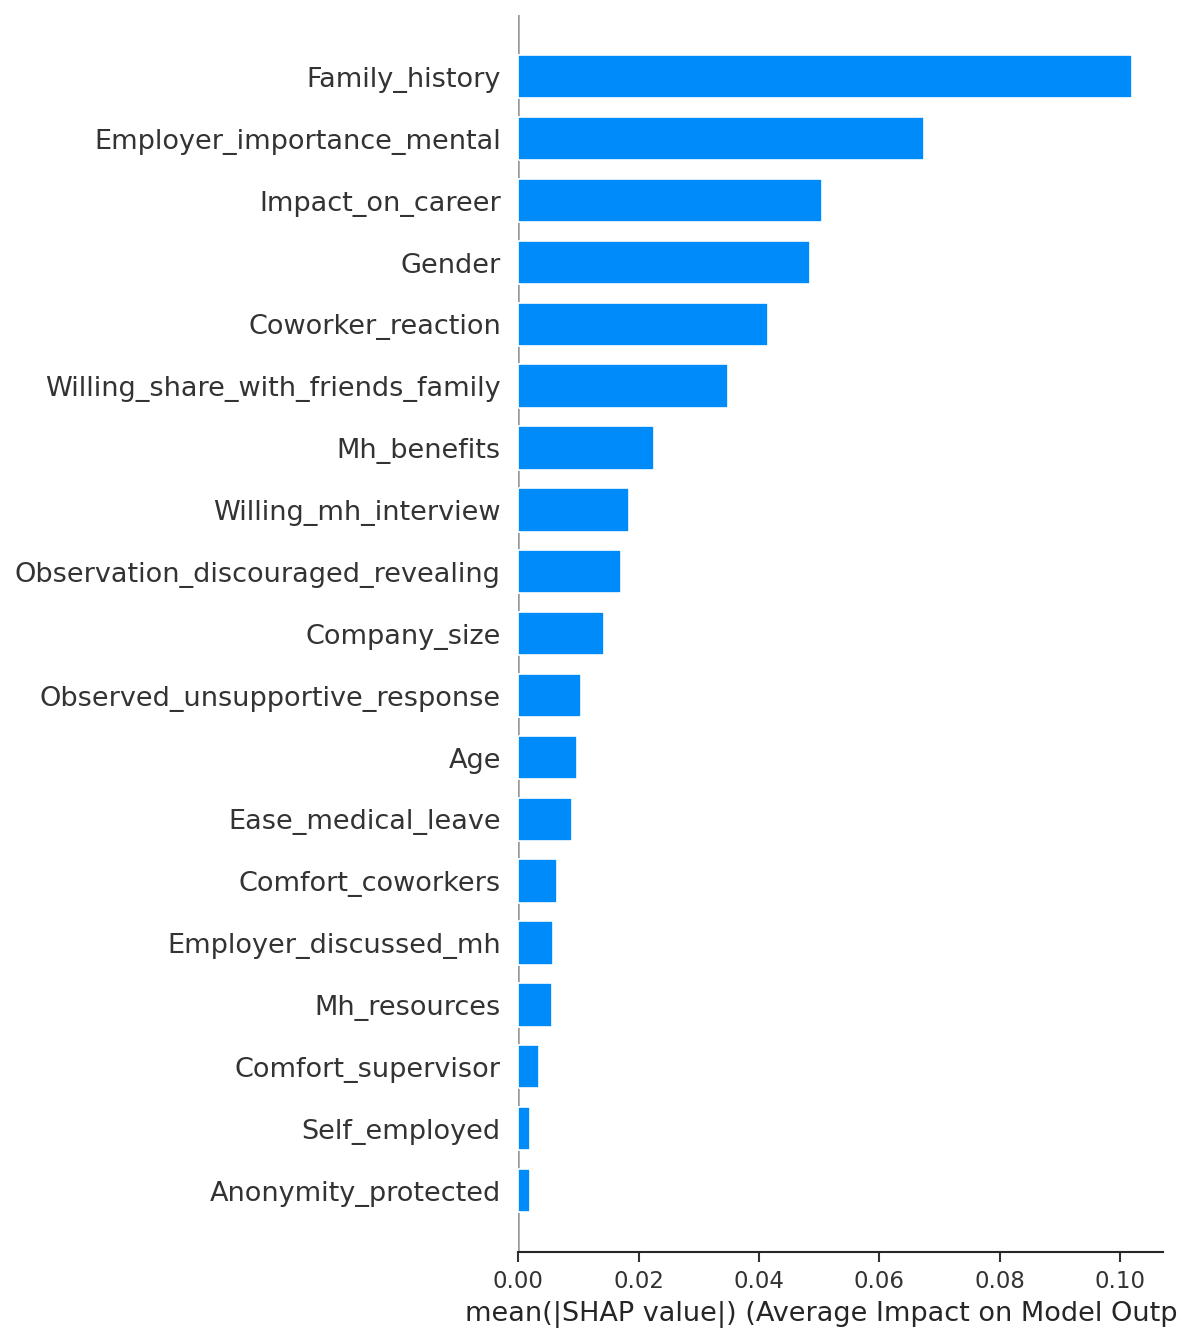

In [25]:
male_shap = shap_obj[male_mask]
female_shap = shap_obj[female_mask]

# --- PLOT FOR MALES ---
plt.figure(figsize=(10, 6))
shap.summary_plot(
    male_shap,
    X_test[male_mask],
    plot_type="bar",
    show=False
)

print("Top Global Predictors: Male Respondents\n(Mean Absolute SHAP Value)")
plt.xlabel("mean(|SHAP value|) (Average Impact on Model Output)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_bar_male.pdf"))
plt.show()

# --- PLOT FOR FEMALES ---
plt.figure(figsize=(10, 6))
shap.summary_plot(
    female_shap,
    X_test[female_mask],
    plot_type="bar",
    show=False
)

print("Top Global Predictors: Female Respondents\n(Mean Absolute SHAP Value)")
plt.xlabel("mean(|SHAP value|) (Average Impact on Model Output)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "shap_bar_female.pdf"))
plt.show()